<a href="https://colab.research.google.com/github/Zuzed22/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes/blob/main/TelecomX_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracción

In [38]:
import pandas as pd
import numpy as np


url = "https://github.com/alura-cursos/challenge2-data-science-LATAM/raw/main/TelecomX_Data.json"
df_raw = pd.read_json(url)

#### Normalización y aplanamiento del JSON

In [39]:
def flatten_df(df, sep="_"):
    df = df.copy()


    list_cols = [c for c in df.columns
                 if df[c].apply(lambda x: isinstance(x, list)).any()]
    for col in list_cols:
        df = df.explode(col, ignore_index=True)


    while True:
        dict_cols = [c for c in df.columns
                     if df[c].apply(lambda x: isinstance(x, dict)).any()]
        if not dict_cols:
            break

        for col in dict_cols:
            norm = (
                pd.json_normalize(df[col])
                  .add_prefix(f"{col}{sep}"))
            df = pd.concat(
                [df.drop(columns=[col]).reset_index(drop=True),
                 norm.reset_index(drop=True)],
                axis=1)
    return df

#🔧 Transformación

#### Limpieza y transformación

In [40]:
df_flat = flatten_df(df_raw)


df_flat['account_Charges.Total'] = (
    df_flat['account_Charges.Total']
        .replace(r'^\s*$', np.nan, regex=True)
        .astype(float))

In [41]:
rename_cols = {
    'index': 'Indice',
    'customerID': 'Id_cliente',
    'Churn': 'Churn',
    'customer_gender': 'Genero_cliente',
    'customer_SeniorCitizen': 'Cliente_senior',
    'customer_Partner': 'Cliente_partner',
    'customer_Dependents': 'Cliente_dependiente',
    'customer_tenure': 'Antiguedad_cliente',
    'phone_PhoneService': 'Servicio_telefono',
    'phone_MultipleLines': 'Multiples_lineas',
    'internet_InternetService': 'Servicio_internet',
    'internet_OnlineSecurity': 'Seguridad_online',
    'internet_OnlineBackup': 'Respaldo_online',
    'internet_DeviceProtection': 'Proteccion_dispositivos',
    'internet_TechSupport': 'Soporte_tecnico',
    'internet_StreamingTV': 'Streaming',
    'internet_StreamingMovies': 'Peliculas_streaming',
    'account_Contract': 'Contrato',
    'account_PaperlessBilling': 'Boleta_electronica',
    'account_PaymentMethod': 'Metodo_pago',
    'account_Charges.Monthly': 'Cargo_mensual',
    'account_Charges.Total': 'Cargo_total'}

#### Codificación de la variable objetivo

In [42]:
df_flat.rename(columns=rename_cols, inplace=True)
if 'Indice' in df_flat.columns:

    df_flat.set_index('Indice', inplace=True, drop=True)

df_flat.to_parquet("telecomx_flat_renombrado.parquet", index=False)
churn_total = df_flat['Churn'].sum()
df_flat['Churn'] = df_flat['Churn'].map({'Yes': 1, 'No': 0})

churn_total = df_flat['Churn'].sum()
churn_total_porcentaje = (churn_total / len(df_flat)) * 100

df_flat.head()

,Id_cliente,Churn,Genero_cliente,Cliente_senior,Cliente_partner,Cliente_dependiente,Antiguedad_cliente,Servicio_telefono,Multiples_lineas,Servicio_internet,...,Respaldo_online,Proteccion_dispositivos,Soporte_tecnico,Streaming,Peliculas_streaming,Contrato,Boleta_electronica,Metodo_pago,Cargo_mensual,Cargo_total
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,1.0,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1.0,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1.0,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


#📊 Carga y análisis

#### Análisis descriptivo básico

In [43]:
df_no_churn = df_flat[df_flat['Churn'] == 0]
df_churn = df_flat[df_flat['Churn'] == 1]
no_churn_total = len(df_no_churn)
no_churn_pct   = no_churn_total / len(df_flat) * 100

nulos_churn = df_flat['Churn'].isna().sum()

df_clean = df_flat.dropna(subset=['Churn'])

total_clean = len(df_clean)
activos_pct = (df_clean['Churn'] == 0).sum() / total_clean * 100
cancelados_pct = (df_clean['Churn'] == 1).sum() / total_clean * 100

print(f"Filas tras limpieza: {total_clean}")
print(f"Activos:    {activos_pct:.2f}%")
print(f"Cancelados: {cancelados_pct:.2f}%")
print(f"Suma total: {(activos_pct + cancelados_pct):.2f}%")

df_no_churn.head()

Filas tras limpieza: 7043
Activos:    73.46%
Cancelados: 26.54%
Suma total: 100.00%


,Id_cliente,Churn,Genero_cliente,Cliente_senior,Cliente_partner,Cliente_dependiente,Antiguedad_cliente,Servicio_telefono,Multiples_lineas,Servicio_internet,...,Respaldo_online,Proteccion_dispositivos,Soporte_tecnico,Streaming,Peliculas_streaming,Contrato,Boleta_electronica,Metodo_pago,Cargo_mensual,Cargo_total
0,0002-ORFBO,0.0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.30
1,0003-MKNFE,0.0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.40
5,0013-MHZWF,0.0,Female,0,No,Yes,9,Yes,No,DSL,...,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),69.40,571.45
6,0013-SMEOE,0.0,Female,1,Yes,No,71,Yes,No,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),109.70,7904.25
7,0014-BMAQU,0.0,Male,0,Yes,No,63,Yes,Yes,Fiber optic,...,No,No,Yes,No,No,Two year,Yes,Credit card (automatic),84.65,5377.80


#### Análisis Exploratorio (EDA)

- Comparativa entre hombres y mujeres.
- Distribución entre clientes que cancelaron (churn) y no cancelaron.
- Separación entre clientes adultos mayores (1) y no seniors (0).
- Claramente útil para detectar si los clientes mayores tienden más al churn.
- Clientes agrupados por su tiempo de permanencia.
- Evaluación de lealtad/fidelidad frente al churn.

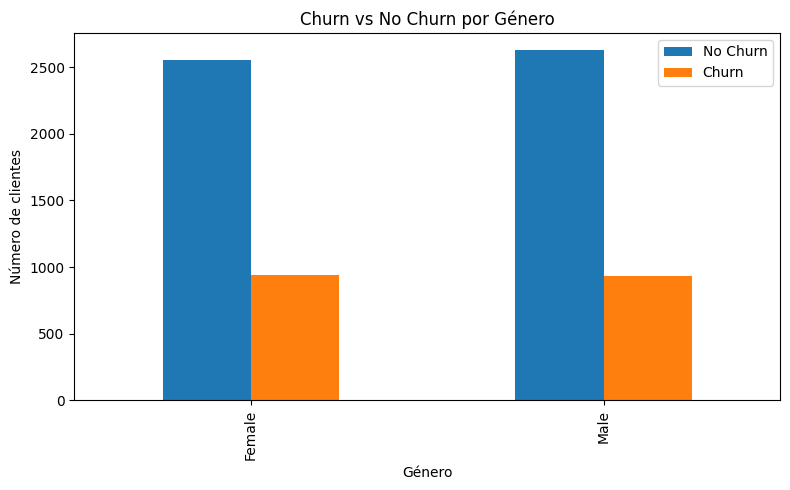

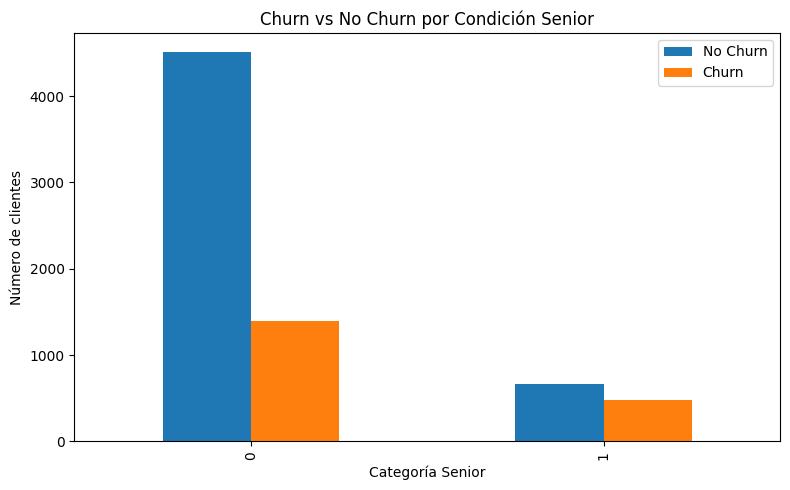

In [44]:
import matplotlib.pyplot as plt

#  Gráfico por género
gender_counts = df_clean.groupby(['Genero_cliente', 'Churn']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

#  Gráfico Senior
senior_counts = df_clean.groupby(['Cliente_senior', 'Churn']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()


df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['Antiguedad_cliente'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'Categoria_fidelidad'] = pd.cut(
    df_tmp['Antiguedad_cliente'],
    bins=bins, labels=labels, right=False)

In [45]:
# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['Categoria_fidelidad', 'Churn'], observed=True)
      .size()
      .unstack(fill_value=0))

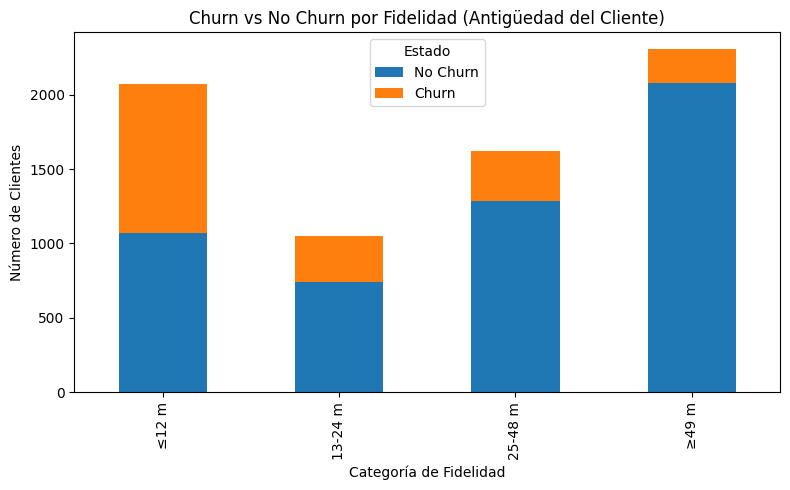

In [46]:
# 3) Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()

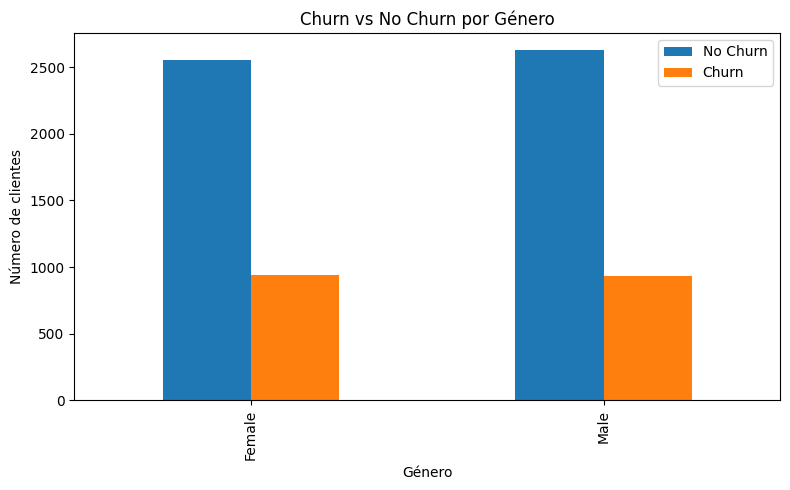

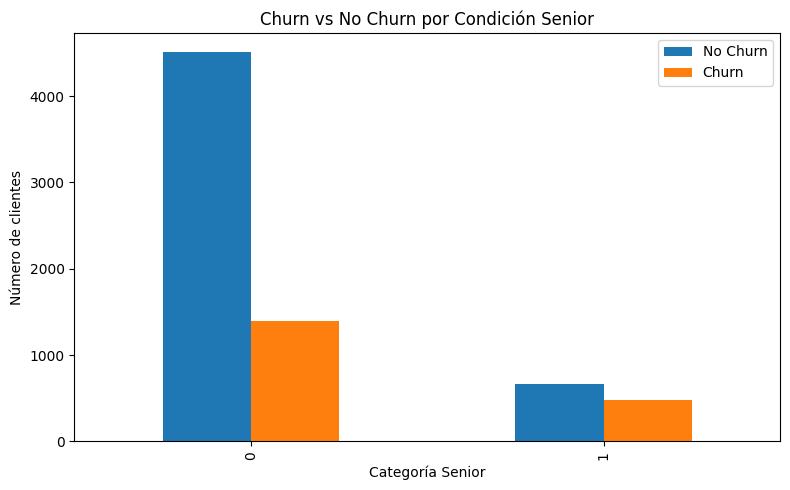

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

#  Gráfico por Género
gender_counts = df_clean.groupby(['Genero_cliente', 'Churn']).size().unstack(fill_value=0)
gender_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Género')
plt.xlabel('Género')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

#  Gráfico por Senior
senior_counts = df_clean.groupby(['Cliente_senior', 'Churn']).size().unstack(fill_value=0)
senior_counts.plot(kind='bar', figsize=(8, 5))
plt.title('Churn vs No Churn por Condición Senior')
plt.xlabel('Categoría Senior')
plt.ylabel('Número de clientes')
plt.legend(['No Churn', 'Churn'])
plt.tight_layout()
plt.show()

In [48]:
df_tmp = df_clean.copy()
bins   = [0, 12, 24, 48, df_tmp['Antiguedad_cliente'].max() + 1]
labels = ['≤12 m', '13-24 m', '25-48 m', '≥49 m']

df_tmp.loc[:, 'Categoria_fidelidad'] = pd.cut(
    df_tmp['Antiguedad_cliente'],
    bins=bins, labels=labels, right=False)

In [49]:
# 2) Tabla de frecuencias (stacked) — indicamos observed para silenciar el aviso
fid_counts = (
    df_tmp
      .groupby(['Categoria_fidelidad', 'Churn'], observed=True)
      .size()
      .unstack(fill_value=0))

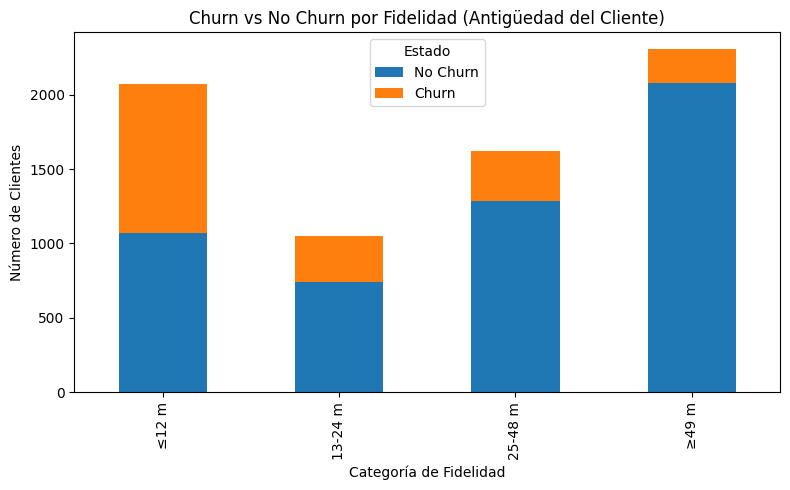

                     total  fugitivos  pct_churn
Categoria_fidelidad                             
≤12 m                 2069      999.0  48.284195
13-24 m               1047      309.0  29.512894
25-48 m               1624      339.0  20.874384
≥49 m                 2303      222.0   9.639601


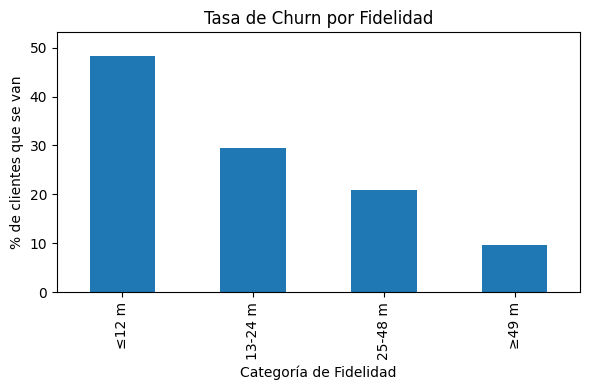

In [50]:
# 3) Gráfico
fid_counts.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title('Churn vs No Churn por Fidelidad (Antigüedad del Cliente)')
plt.xlabel('Categoría de Fidelidad')
plt.ylabel('Número de Clientes')
plt.legend(['No Churn', 'Churn'], title='Estado')
plt.tight_layout()
plt.show()

tasa_churn = (
    df_tmp
      .groupby('Categoria_fidelidad', observed=True)['Churn']
      .agg(total='size', # Changed from ('Churn', 'size') to 'size'
           fugitivos='sum') # Changed from ('Churn', 'sum') to 'sum'
      .assign(pct_churn=lambda x: x['fugitivos'] / x['total']*100))

print(tasa_churn[['total', 'fugitivos', 'pct_churn']])

tasa_churn['pct_churn'].plot(kind='bar', figsize=(6,4))
plt.title('Tasa de Churn por Fidelidad')
plt.ylabel('% de clientes que se van')
plt.xlabel('Categoría de Fidelidad')
plt.ylim(0, tasa_churn['pct_churn'].max() * 1.1)
plt.tight_layout()
plt.show()

                     total  fugitivos  pct_churn
Categoria_fidelidad                             
≤12 m                 2069      999.0  48.284195
13-24 m               1047      309.0  29.512894
25-48 m               1624      339.0  20.874384
≥49 m                 2303      222.0   9.639601


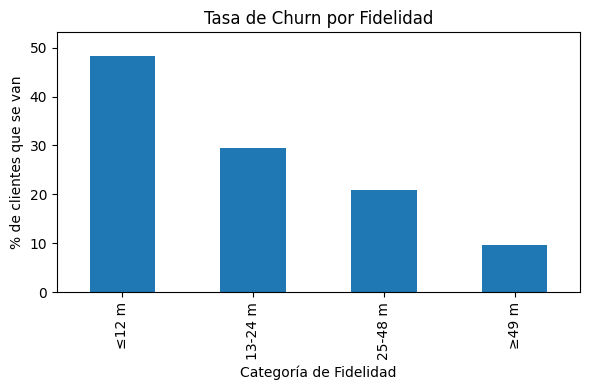


----- Servicio_internet -----
Churn              Churn  No Churn  Pct_Churn
Servicio_internet                            
DSL                  459      1962  18.959108
Fiber optic         1297      1799  41.892765
No                   113      1413   7.404980


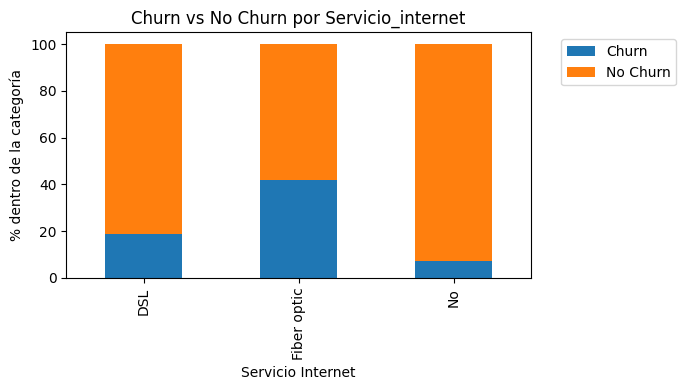


----- Contrato -----
Churn           Churn  No Churn  Pct_Churn
Contrato                                  
Month-to-month   1655      2220  42.709677
One year          166      1307  11.269518
Two year           48      1647   2.831858


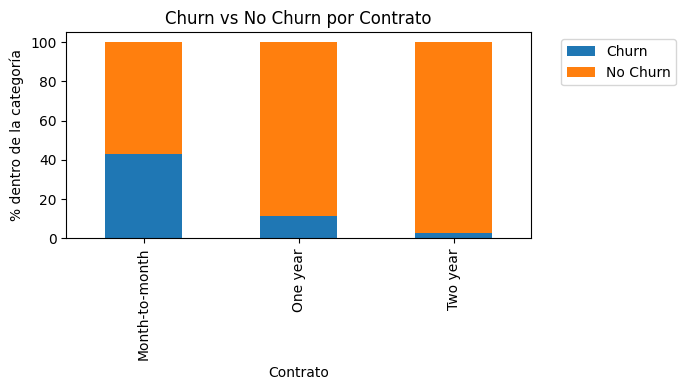


----- Metodo_pago -----
Churn                      Churn  No Churn  Pct_Churn
Metodo_pago                                          
Bank transfer (automatic)    258      1286  16.709845
Credit card (automatic)      232      1290  15.243101
Electronic check            1071      1294  45.285412
Mailed check                 308      1304  19.106700


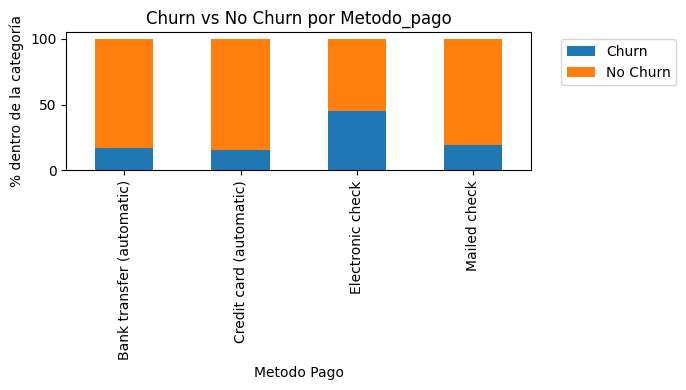


----- Seguridad_online -----
Churn                Churn  No Churn  Pct_Churn
Seguridad_online                               
No                    1461      2037  41.766724
No internet service    113      1413   7.404980
Yes                    295      1724  14.611194


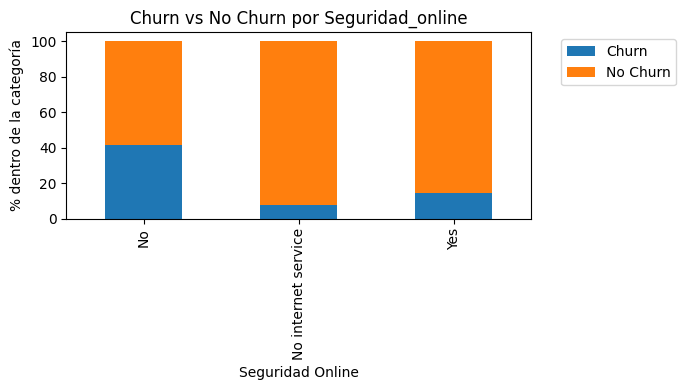


----- Streaming -----
Churn                Churn  No Churn  Pct_Churn
Streaming                                      
No                     942      1868  33.523132
No internet service    113      1413   7.404980
Yes                    814      1893  30.070188


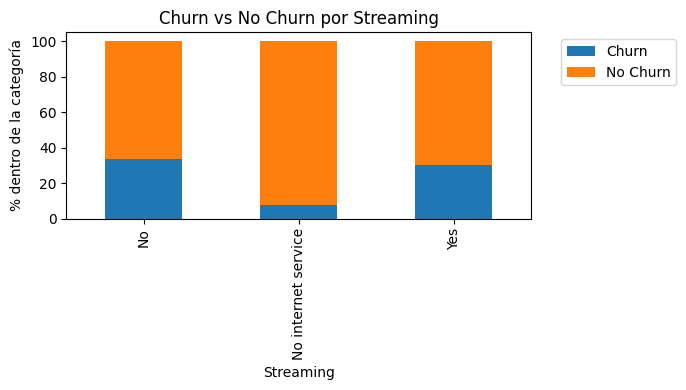


----- Cliente_senior -----
Churn           Churn  No Churn  Pct_Churn
Cliente_senior                            
0                1393      4508  23.606168
1                 476       666  41.681261


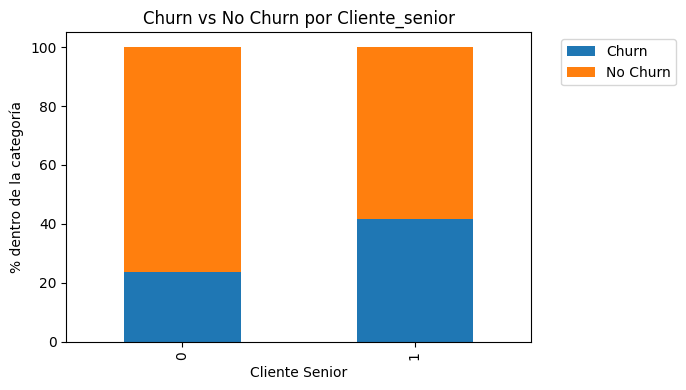

In [51]:
tasa_churn = (
    df_tmp
      .groupby('Categoria_fidelidad', observed=True)['Churn']
      .agg(total='size', # Changed from ('Churn', 'size') to 'size'
           fugitivos='sum') # Changed from ('Churn', 'sum') to 'sum'
      .assign(pct_churn=lambda x: x['fugitivos'] / x['total']*100)
)
print(tasa_churn[['total', 'fugitivos', 'pct_churn']])

tasa_churn['pct_churn'].plot(kind='bar', figsize=(6,4))
plt.title('Tasa de Churn por Fidelidad')
plt.ylabel('% de clientes que se van')
plt.xlabel('Categoría de Fidelidad')
plt.ylim(0, tasa_churn['pct_churn'].max() * 1.1)
plt.tight_layout()
plt.show()

# --- A) Filtrar fugitivos y no fugitivos
df_churn = df_tmp[df_tmp['Churn'] == 1]        # desertores
df_no_churn = df_tmp[df_tmp['Churn'] == 0]     # activos

# --- B) Variables a cruzar -------------
vars_a_cruzar = [
    'Servicio_internet', 'Contrato', 'Metodo_pago',
    'Seguridad_online', 'Streaming',
    'Cliente_senior']

# --- C) Loop para tablas y gráficos ----
for col in vars_a_cruzar:
    print(f"\n----- {col} -----")

    # 1. Tabla con % dentro de cada categoría
    tabla = (
        df_tmp
          .groupby([col, 'Churn'], observed=True)['Id_cliente']
          .count()
          .unstack(fill_value=0)
          .rename(columns={0: 'No Churn', 1: 'Churn'})
    )
    tabla['Pct_Churn'] = tabla['Churn'] / tabla.sum(axis=1) * 100
    print(tabla[['Churn', 'No Churn', 'Pct_Churn']])

# 2. Gráfico de barras apiladas (%)
    tabla_pct = tabla[['Churn', 'No Churn']].div(tabla[['Churn', 'No Churn']].sum(axis=1), axis=0) * 100
    tabla_pct.plot(kind='bar', stacked=True, figsize=(7,4))
    plt.title(f"Churn vs No Churn por {col}")
    plt.ylabel('% dentro de la categoría')
    plt.xlabel(col.replace('_', ' ').title())
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [52]:
# Definir reglas del segmento de alto riesgo
segmento = (
    (df_tmp['Categoria_fidelidad'] == '≤12 m') &
    (df_tmp['Contrato'] == 'Month-to-month') &
    (df_tmp['Servicio_internet'] == 'Fiber optic') &
    (df_tmp['Metodo_pago'] == 'Electronic check'))

# Subset de clientes
df_riesgo = df_tmp[segmento]

# Métricas
total_seg  = len(df_riesgo)
churn_seg  = df_riesgo['Churn'].sum()
pct_churn  = churn_seg / total_seg * 100

print(f"Clientes en segmento crítico: {total_seg}")
print(f"Fugitivos en segmento crítico: {churn_seg}  ({pct_churn:.1f} %)")

df_riesgo['Cargo_mensual'].describe()

# A) Base comparativa
no_churn = df_tmp[df_tmp['Churn'] == 0]['Cargo_mensual']
otros_churn = df_tmp[(df_tmp['Churn'] == 1) & (~segmento)]['Cargo_mensual']

print("Promedio No-Churn:", no_churn.mean().round(2))
print("Promedio Otros Churn:", otros_churn.mean().round(2))
print("Promedio Segmento Crítico:", df_riesgo['Cargo_mensual'].mean().round(2))

Clientes en segmento crítico: 606
Fugitivos en segmento crítico: 435.0  (71.8 %)
Promedio No-Churn: 61.27
Promedio Otros Churn: 72.0
Promedio Segmento Crítico: 82.01


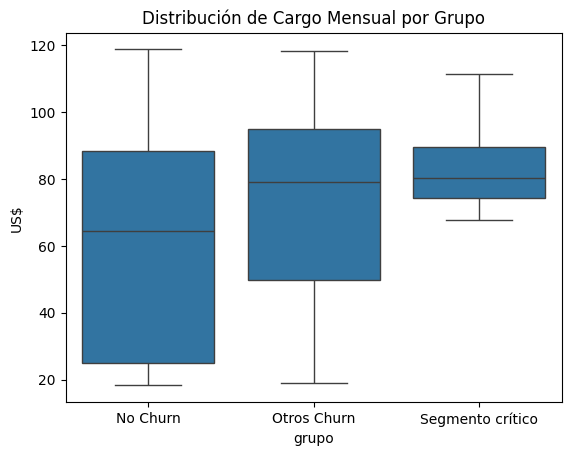

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

df_plot = (
    pd.concat([
        df_tmp[df_tmp['Churn'] == 0].assign(grupo='No Churn'),
        df_tmp[(df_tmp['Churn'] == 1) & (~segmento)].assign(grupo='Otros Churn'),
        df_riesgo.assign(grupo='Segmento crítico')]))

sns.boxplot(x='grupo', y='Cargo_mensual', data=df_plot)
plt.title('Distribución de Cargo Mensual por Grupo')
plt.ylabel('US$')
plt.show()

#📄Informe final